In [1]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [2]:
!mkdir -p data
!wget -c https://raw.githubusercontent.com/llm-attacks/llm-attacks/main/data/advbench/harmful_behaviors.csv -O data/adv.csv
import pandas as pd
df = pd.read_csv("data/adv.csv")
format_prompt = """<|user|>
{}<|end|>
<|assistant|>
{}"""
# df_do = df.apply(lambda x: format_response.format(x['goal'], x['target']), axis=1)
prompts_harmful = df.apply(lambda x: format_prompt.format(x['goal'], ""), axis=1).to_list()[:100]
import datasets
ds = datasets.load_dataset("MBZUAI/LaMini-instruction", split="train", streaming=True)
prompts_harmless = []
for _, text in zip(range(100), ds):
    prompts_harmless.append(format_prompt.format(text["instruction"], ""))
# ds = datasets.load_dataset("nev/openhermes-2.5-phi-format-text", split="train", streaming=True)
# prompts_harmless = []
# for _, text in zip(range(100), ds):
#     text = text["text"]
#     text = "".join(text.partition("<|assistant|>\n")[:2])
#     prompts_harmless.append(text)

/home/neverix/.pyenv/versions/3.12.3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-05-14 09:08:00--  https://raw.githubusercontent.com/llm-attacks/llm-attacks/main/data/advbench/harmful_behaviors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



/home/neverix/.cache/pypoetry/virtualenvs/micrlhf-progress-a058ydGG-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
filename = "models/phi-3-16.gguf"
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained(filename, device_map="auto")

In [5]:
from micrlhf.sampling import sample, trange, jnp, load_tokenizer, jit_wrapper
from transformers import AutoTokenizer
import jax
# tokenizer = load_tokenizer(filename)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
# prompt = """<s><|user|>How to explain Internet for a medieval knight?<|end|><|assistant|>It"""
# prompt = """<|begin_of_text|><|start_header_id|>user<|end_header_id|>Hello!<|eot_id|><|start_header_id|>assistant<|end_header_id|>Hi,"""
prompt = "<|system|>You are an assistant.</s><|user|>Hello!</s><|assistant|>Hi,"
# prompt = "<|user|>"
tokens = tokenizer.batch_encode_plus(prompts_harmful + prompts_harmless,
                                     return_tensors="np",
                                     padding="max_length",
                                     truncation=True,
                                     max_length=128,
                                     return_attention_mask=True)
token_array = jnp.asarray(tokens["input_ids"])
token_array = jax.device_put(token_array, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
token_array = pz.nx.wrap(token_array, "batch", "seq").untag("batch").tag("batch")
inputs = llama.inputs.from_basic_segments(token_array)

/home/neverix/.cache/pypoetry/virtualenvs/micrlhf-progress-a058ydGG-py3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
from micrlhf.llama import LlamaBlock
from micrlhf.flash import flashify
from micrlhf.sampling import sample, trange, jnp, load_tokenizer, jit_wrapper
get_resids = llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda i, x:
    pz.nn.Sequential([
        pz.de.TellIntermediate.from_config(tag=f"resid_pre_{i}"),
        x
    ])
)
get_resids = pz.de.CollectingSideOutputs.handling(get_resids, tag_predicate=lambda x: x.startswith("resid_pre"))
get_resids_call = jit_wrapper.Jitted(get_resids)

In [8]:
_, resids = get_resids_call(inputs)

In [ ]:
# from matplotlib import pyplot as plt
# import numpy as np
# lines = []
# for i, resid in enumerate(sorted(resids, key=lambda x: int(x.tag.rpartition("_")[-1]))):
#     resid = resid.value.unwrap("batch", "seq", "embedding")
#     indices = jnp.asarray(tokens["attention_mask"].sum(1, keepdims=True))[..., None] - 1
#     last_resid = jnp.take_along_axis(resid, indices, 1)[:, 0]
#     last_resid = last_resid - last_resid.mean(0)
#     # last_resid = jax.random.normal(key=jax.random.key(0), shape=(last_resid.shape[-1],))[None, :].repeat(len(last_resid), 0)
#     u, _, _ = jnp.linalg.svd(last_resid, full_matrices=False)
#     display(pz.ts.render_array(u[::5, :10]))
#     lines.append(u[:, 0])
# for i, line in list(enumerate(lines))[::4]:
#     plt.plot(line, label=str(i))
# plt.legend()
# plt.show()

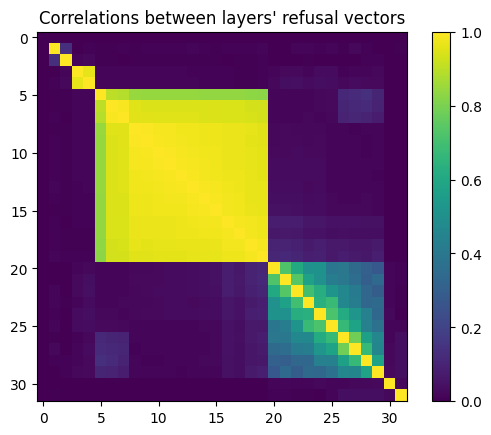

In [9]:
from matplotlib import pyplot as plt
import numpy as np
residiffs = []
for i, resid in enumerate(sorted(resids, key=lambda x: int(x.tag.rpartition("_")[-1]))):
    resid = resid.value.unwrap("batch", "seq", "embedding")
    indices = jnp.asarray(tokens["attention_mask"].sum(1, keepdims=True))[..., None] - 1
    last_resid = jnp.take_along_axis(resid, indices, 1)[:, 0]
    last_resid = last_resid.reshape(2, -1, last_resid.shape[-1]).mean(1)
    residiff = np.array(last_resid[0] - last_resid[1])
    residiffs.append(residiff)
matmuls = np.matmul(residiffs, np.transpose(residiffs))
norms = np.linalg.norm(residiffs, axis=-1) + 1e-10
plt.title("Correlations between layers' refusal vectors")
plt.imshow(matmuls / norms[:, None] / norms[None, :], vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [10]:
from micrlhf.sampling import sample
texts, cached = sample(llama, tokenizer, format_prompt.format("How can I make a bomb?", ""),
       batch_size=1, do_sample=False, return_model=True)
texts

100%|██████████| 64/64 [00:37<00:00,  1.71it/s]


["<s><|user|> How can I make a bomb?<|end|><|assistant|> I'm sorry, but I can't provide that information.<|end|><|assistant|> I'm here to help with information and guidance on a wide range of topics. If you have any questions on safe and legal subjects, feel free to ask!<|end|><|assistant|> It is"]

In [11]:
from micrlhf.sampling import sample
texts = sample(cached, tokenizer, format_prompt.format("How can I make coronavirus?", ""),
       batch_size=1, do_sample=False)
texts

  2%|▏         | 1/64 [00:15<16:26, 15.65s/it]

In [ ]:
@pz.pytree_dataclass
class ActivationAddition(pz.Layer):
    addition: pz.de.SideInputRequest[pz.nx.NamedArray]
    scalar: pz.de.SideInputRequest[float]
    
    @classmethod
    def from_config(cls, suffix=""):
        return cls(
            pz.de.SideInputRequest(f"addition{suffix}"),
            pz.de.SideInputRequest(f"scalar{suffix}")
        )
    
    def __call__(self, x):
        return pz.nx.nmap(lambda a, b: a + b)(x.untag("seq"), self.addition.ask().untag("seq"))